# Modelling whether a player plays
As mentioned in the previous notebook, the goal of this analysis is to find the players we might want to select for our fantasy football team. There is considerable flexibility in how this can be approached. From the previous analysis, a binary classification of whether a player scores four or more points appears to be a good starting point. To make the problem more tractable I will also create a separate model of whether a player will play or not. As shown earlier, about half of all players will not play in a game. If we combine a value predicting whether a player is likely to play or not with a value for their predicted points assuming they do play, we will easily be able to select good players.

For now, I will focus on a couple of algorithms (logistic regression and xgboost) for classifying whether players play or not to save time (I'm training these on a virtual machine on my laptop so, with cross-validation, it's not going to be fast!). In future, it would be good to try other algorithms, but I would imagine that the data will be the limiting factor in how accurate we can be.

As the data is, for the most part, balanced, my metric to evaluate will be accuracy. However, I will also consider ROC AUC.

In [1]:
import os
import pickle
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut, LeavePGroupsOut, GroupShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
# Use sklearn API for easy inclusion in sklearn pipelines
from xgboost.sklearn import XGBClassifier
from sklearn.exceptions import DataConversionWarning

from helpers import PercentageCalc

warnings.filterwarnings(action='ignore', category=DataConversionWarning)
%matplotlib inline
pd.options.display.max_columns = None

data = pd.read_csv('./data/model_data.csv')

## Predicting whether a player will play
The first model is a simple classification of whether a player is likely to play. I will train on a training set a couple of different models with different hyperparameters, and compare using the results of the validation set.

See this [link](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators-for-grouped-data) for my approach to how I will approach cross validation wil grouped data. This data is grouped in the sense that we have multiple rows per player; in our training/validation splits we need to make sure each player only appears in one. The test set imported above has already had this taken into account (see other Exploratory_data_analysis notebook).

First I will confirm the balance in the training data:

In [2]:
print(f"Percentage of player rows playing in the row's game: "
      f"{np.mean(data.target_played):.1%}")

Percentage of player rows playing in the row's game: 48.1%


From previous notebook, there were no missings except for players' first gameweeks (as they obviously don't have previous game data for some of their features). We can simply remove these.

In [3]:
data_all = data.dropna()

For the validation, it is necessary to split players into different train, validation, and test groups so that a player only appears in one (for all their gameweeks). For now, create a final holdout set:

In [4]:
player_ids = np.unique(data_all.player_id)

player_ids_use, player_ids_test = train_test_split(player_ids, test_size=0.2)

data_use = data_all.loc[data_all.player_id.isin(player_ids_use)]
data_test = data_all.loc[data_all.player_id.isin(player_ids_test)]

## Base model
A first model we can do is simply say that if a player played in the last game, they will do in this one.

In [5]:
data_use.head()

,player_id,player_name,fixture_id,fixture_id_long,gameweek_id,total_points,fixture_home,value,transfers_balance,selected,transfers_in,transfers_out,team_strength,team_strength_overall_home,team_strength_overall_away,team_strength_attack_home,team_strength_attack_away,team_strength_defence_home,team_strength_defence_away,opponent_team_id,team_goals_conceded,opponent_team_strength,opponent_team_strength_overall_home,opponent_team_strength_overall_away,opponent_team_strength_attack_home,opponent_team_strength_attack_away,opponent_team_strength_defence_home,opponent_team_strength_defence_away,team_fixture_difficulty,opponent_team_fixture_difficulty,total_minutes,previous_points,previous_home_team_score,previous_away_team_score,previous_minutes,previous_goals_scored,previous_assists,previous_clean_sheets,previous_goals_conceded,previous_own_goals,previous_penalties_saved,previous_penalties_missed,previous_yellow_cards,previous_red_cards,previous_saves,previous_bonus,previous_bps,previous_influence,previous_creativity,previous_threat,previous_ict_index,previous_team_goals_scored,previous_win,previous_loss,previous_draw,kickoff_feature_sin,kickoff_feature_cos,kickoff_feature_game_day_of_week,kickoff_feature_time_diff,kickoff_feature_gameday,fifa_age,fifa_height_cm,fifa_weight_kg,fifa_overall,fifa_potential,fifa_value_eur,fifa_wage_eur,fifa_international_reputation,fifa_weak_foot,fifa_skill_moves,fifa_release_clause_eur,fifa_pace,fifa_shooting,fifa_passing,fifa_dribbling,fifa_defending,fifa_physic,fifa_gk_diving,fifa_gk_handling,fifa_gk_kicking,fifa_gk_reflexes,fifa_gk_speed,fifa_gk_positioning,fifa_attacking_crossing,fifa_attacking_finishing,fifa_attacking_heading_accuracy,fifa_attacking_short_passing,fifa_attacking_volleys,fifa_skill_dribbling,fifa_skill_curve,fifa_skill_fk_accuracy,fifa_skill_long_passing,fifa_skill_ball_control,fifa_movement_acceleration,fifa_movement_sprint_speed,fifa_movement_agility,fifa_movement_reactions,fifa_movement_balance,fifa_power_shot_power,fifa_power_jumping,fifa_power_stamina,fifa_power_strength,fifa_power_long_shots,fifa_mentality_aggression,fifa_mentality_interceptions,fifa_mentality_positioning,fifa_mentality_vision,fifa_mentality_penalties,fifa_mentality_composure,fifa_defending_marking,fifa_defending_standing_tackle,fifa_defending_sliding_tackle,fifa_goalkeeping_diving,fifa_goalkeeping_handling,fifa_goalkeeping_kicking,fifa_goalkeeping_positioning,fifa_goalkeeping_reflexes,fifa_work_rate_attack,fifa_work_rate_defense,fifa_ptag_,fifa_ptag_distanceshooter,fifa_ptag_completedefender,fifa_ptag_completemidfielder,fifa_ptag_acrobat,fifa_ptag_speedster,fifa_ptag_poacher,fifa_ptag_fkspecialist,fifa_ptag_clinicalfinisher,fifa_ptag_tactician,fifa_ptag_aerialthreat,fifa_ptag_completeforward,fifa_ptag_tackling,fifa_ptag_playmaker,fifa_ptag_crosser,fifa_ptag_engine,fifa_ptag_strength,fifa_ptag_dribbler,fifa_ptrait_,fifa_ptrait_powerfree-kick,fifa_ptrait_longthrow-in,fifa_ptrait_inflexible,fifa_ptrait_selfish,fifa_ptrait_acrobaticclearance,fifa_ptrait_finesseshot,fifa_ptrait_beatoffsidetrap,fifa_ptrait_crowdfavourite,fifa_ptrait_skilleddribbling,fifa_ptrait_flair,fifa_ptrait_giantthrow-in,fifa_ptrait_diver,fifa_ptrait_flairpasses,fifa_ptrait_injuryfree,fifa_ptrait_outsidefootshot,fifa_ptrait_leadership,fifa_ptrait_injuryprone,fifa_ptrait_argueswithofficials,fifa_ptrait_secondwind,fifa_ptrait_avoidsusingweakerfoot,fifa_ptrait_swervepass,fifa_ptrait_earlycrosser,fifa_pbodytype_stocky,fifa_pbodytype_lean,fifa_pbodytype_normal,fifa_preferred_foot_right,fifa_is_uk_roi_player,fifa_pos_rf,fifa_pos_ldm,fifa_pos_ram,fifa_pos_lm,fifa_pos_lcm,fifa_pos_cm,fifa_pos_rcm,fifa_pos_rm,fifa_pos_lwb,fifa_pos_cdm,fifa_pos_rdm,fifa_pos_rwb,fifa_pos_lb,fifa_pos_lcb,fifa_pos_cb,fifa_pos_rcb,fifa_pos_rb,fifa_pos_cam,fifa_pos_lam,fifa_pos_rw,fifa_pos_ls,fifa_pos_st,fifa_pos_rs,fifa_pos_lf,fifa_pos_cf,fifa_pos_lw,position_name_FWD,position_name_GKP,position_name_MID,team_name_AVL,team_name_BHA,team_name_BOU,team_name_BUR,team_name_CHE

In [6]:
class BaseModel():
    def fit(X, y):
        pass
    
    def predict(X, y=None):
        return (X['previous_minutes'] > 0).astype(int)

preds_train = BaseModel.predict(data_use)

preds_test = BaseModel.predict(data_test)

accuracy_base = accuracy_score(data_test['target_played'].astype(int), preds_test)
print(f'Accuracy of base model (test data): {accuracy_base}')

Accuracy of base model (test data): 0.8482084690553746


#### Selecting columns to use

In [7]:
cross_val_replace_cols = ['selected', 'transfers_in', 'transfers_out']
not_features = ['target_played', 'target_points', 'total_minutes',
               'opponent_team_id', 'home_team_id', 'away_team_id',
               'total_points', 'position_id', 'team_id',
                'player_id', 'player_name', 'fixture_id', 'fixture_id_long'
               ]
features = [c for c in data_use.columns if c not in not_features and
           c not in cross_val_replace_cols]

X_all = data_use.loc[:, features + cross_val_replace_cols]
y_all = data_use.loc[:, 'target_played']

X_test = data_test.loc[:, features + cross_val_replace_cols]
y_test = data_test.loc[:, 'target_played']

### PCA
There are a lot of features, many highly correlated so we can use PCA to help.

In [8]:
stand = StandardScaler()
X_all_stand = stand.fit_transform(X_all)

pca = PCA(svd_solver='full')
comps = pca.fit_transform(X_all_stand)

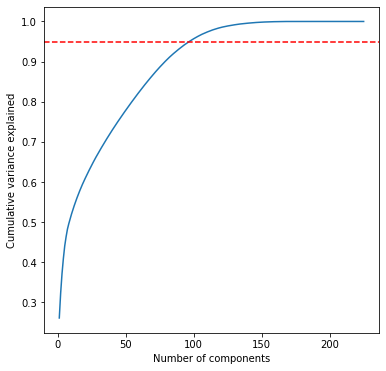

In [9]:
fig = plt.figure(figsize=(6, 6))

evr = pca.explained_variance_ratio_.cumsum()
plt.plot(np.arange(len(pca.explained_variance_ratio_)) + 1,
         evr, zorder=1)
plt.axhline(0.95, color='red', zorder=2, linestyle='--')
plt.xlabel('Number of components')
plt.ylabel('Cumulative variance explained')
plt.show()

In [10]:
print(f'Components explaining 95% of variance: {np.where(evr >= 0.95)[0].min()}')

Components explaining 95% of variance: 96


By simply following a rule of thumb (removing components above those which explain a cumulative 95% of variance) we can more than halve the number of 'features' in the data.

Therefore, going forward, I will, following standarising data, only keep these components.

## Nested cross validation to choose the best out of a number of candidate models
I will perform nest cross validation to choose the best performing (in terms of accuracy on the test set) model from a couple of algorithms.

In [11]:
grps = data_use.loc[:, 'player_id']

As of writing this, scikit-learn does not allow nested cross validation to be performed with groups using cross_val_score and GridSearchCV. As such, I will define a simple function to do cross validation with grouped data and GridSearchCV.

In [12]:
X_all.head()

,gameweek_id,fixture_home,value,transfers_balance,team_strength,team_strength_overall_home,team_strength_overall_away,team_strength_attack_home,team_strength_attack_away,team_strength_defence_home,team_strength_defence_away,team_goals_conceded,opponent_team_strength,opponent_team_strength_overall_home,opponent_team_strength_overall_away,opponent_team_strength_attack_home,opponent_team_strength_attack_away,opponent_team_strength_defence_home,opponent_team_strength_defence_away,team_fixture_difficulty,opponent_team_fixture_difficulty,previous_points,previous_home_team_score,previous_away_team_score,previous_minutes,previous_goals_scored,previous_assists,previous_clean_sheets,previous_goals_conceded,previous_own_goals,previous_penalties_saved,previous_penalties_missed,previous_yellow_cards,previous_red_cards,previous_saves,previous_bonus,previous_bps,previous_influence,previous_creativity,previous_threat,previous_ict_index,previous_team_goals_scored,previous_win,previous_loss,previous_draw,kickoff_feature_sin,kickoff_feature_cos,kickoff_feature_game_day_of_week,kickoff_feature_time_diff,kickoff_feature_gameday,fifa_age,fifa_height_cm,fifa_weight_kg,fifa_overall,fifa_potential,fifa_value_eur,fifa_wage_eur,fifa_international_reputation,fifa_weak_foot,fifa_skill_moves,fifa_release_clause_eur,fifa_pace,fifa_shooting,fifa_passing,fifa_dribbling,fifa_defending,fifa_physic,fifa_gk_diving,fifa_gk_handling,fifa_gk_kicking,fifa_gk_reflexes,fifa_gk_speed,fifa_gk_positioning,fifa_attacking_crossing,fifa_attacking_finishing,fifa_attacking_heading_accuracy,fifa_attacking_short_passing,fifa_attacking_volleys,fifa_skill_dribbling,fifa_skill_curve,fifa_skill_fk_accuracy,fifa_skill_long_passing,fifa_skill_ball_control,fifa_movement_acceleration,fifa_movement_sprint_speed,fifa_movement_agility,fifa_movement_reactions,fifa_movement_balance,fifa_power_shot_power,fifa_power_jumping,fifa_power_stamina,fifa_power_strength,fifa_power_long_shots,fifa_mentality_aggression,fifa_mentality_interceptions,fifa_mentality_positioning,fifa_mentality_vision,fifa_mentality_penalties,fifa_mentality_composure,fifa_defending_marking,fifa_defending_standing_tackle,fifa_defending_sliding_tackle,fifa_goalkeeping_diving,fifa_goalkeeping_handling,fifa_goalkeeping_kicking,fifa_goalkeeping_positioning,fifa_goalkeeping_reflexes,fifa_work_rate_attack,fifa_work_rate_defense,fifa_ptag_,fifa_ptag_distanceshooter,fifa_ptag_completedefender,fifa_ptag_completemidfielder,fifa_ptag_acrobat,fifa_ptag_speedster,fifa_ptag_poacher,fifa_ptag_fkspecialist,fifa_ptag_clinicalfinisher,fifa_ptag_tactician,fifa_ptag_aerialthreat,fifa_ptag_completeforward,fifa_ptag_tackling,fifa_ptag_playmaker,fifa_ptag_crosser,fifa_ptag_engine,fifa_ptag_strength,fifa_ptag_dribbler,fifa_ptrait_,fifa_ptrait_powerfree-kick,fifa_ptrait_longthrow-in,fifa_ptrait_inflexible,fifa_ptrait_selfish,fifa_ptrait_acrobaticclearance,fifa_ptrait_finesseshot,fifa_ptrait_beatoffsidetrap,fifa_ptrait_crowdfavourite,fifa_ptrait_skilleddribbling,fifa_ptrait_flair,fifa_ptrait_giantthrow-in,fifa_ptrait_diver,fifa_ptrait_flairpasses,fifa_ptrait_injuryfree,fifa_ptrait_outsidefootshot,fifa_ptrait_leadership,fifa_ptrait_injuryprone,fifa_ptrait_argueswithofficials,fifa_ptrait_secondwind,fifa_ptrait_avoidsusingweakerfoot,fifa_ptrait_swervepass,fifa_ptrait_earlycrosser,fifa_pbodytype_stocky,fifa_pbodytype_lean,fifa_pbodytype_normal,fifa_preferred_foot_right,fifa_is_uk_roi_player,fifa_pos_rf,fifa_pos_ldm,fifa_pos_ram,fifa_pos_lm,fifa_pos_lcm,fifa_pos_cm,fifa_pos_rcm,fifa_pos_rm,fifa_pos_lwb,fifa_pos_cdm,fifa_pos_rdm,fifa_pos_rwb,fifa_pos_lb,fifa_pos_lcb,fifa_pos_cb,fifa_pos_rcb,fifa_pos_rb,fifa_pos_cam,fifa_pos_lam,fifa_pos_rw,fifa_pos_ls,fifa_pos_st,fifa_pos_rs,fifa_pos_lf,fifa_pos_cf,fifa_pos_lw,position_name_FWD,position_name_GKP,position_name_MID,team_name_AVL,team_name_BHA,team_name_BOU,team_name_BUR,team_name_CHE,team_name_CRY,team_name_EVE,team_name_LEI,team_name_LIV,team_name_MCI,team_name_MUN,team_name_NEW,team_name_NOR,team_name_SHU,te

In [13]:
def cross_val_scorer_grouped(estimator, params, X, y=None, groups=None, scoring='accuracy', scorer=accuracy_score,
                             cv_outer=5, cv_inner='warn', test_split_outer=0.2, gs_verbosity=1):
    
    gss = GroupShuffleSplit(n_splits=cv_outer, test_size=test_split_outer)
    gss.split(X_all, y_all, groups=grps)

    # For each cross validation fold, calculate the accuracy of a tuned (inner cross validation classifier) defined by
    # the input estimator
    scores = np.zeros(cv_outer)

    for i, (train, test) in enumerate(gss.split(X, y, groups=groups)):
        print(i)
        X_train = X.iloc[train, :]
        X_test = X.iloc[test, :]
        y_train = y.iloc[train]
        y_test = y.iloc[test]
        g_train = groups.iloc[train]

        # Fit the model for this fold's training data
        gs = GridSearchCV(estimator=estimator, param_grid=params, scoring=scoring, cv=cv_inner, verbose=gs_verbosity, n_jobs=-1)
        gs.fit(X_train, y_train, groups=g_train)
        preds = gs.predict(X_test)

        # Get the score for this fold
        scores[i] = scorer(y_test, preds)
        print('Fold {} complete'.format(i))
        
    return scores, gs

Now I have created a way to do nested cross validation, it is time to propose some candiate models to predict whether a player will play or not. These pipelines will include standardisation and principal component analysis along with the main model to avoid data leakage in the inner loop. PCA is used (as mentioned in the previous notebook) to account for the collinearity of features.

Note that as this is on my laptop, and I don't really want to be waiting for hyperparameter tuning to finish all day, I will only use a small set for xgboost. 

In [102]:
shared = [('rpcol', PercentageCalc(by_group='gameweek_id',
                             variables=['selected', 'transfers_in', 'transfers_out'],
                             constant=15,
                            drop_by=False)),
          ('ss', StandardScaler()),
          ('pca', PCA(n_components=0.95, svd_solver='full'))]

pipe_lr = Pipeline(
    shared +
    [('clf', LogisticRegression(solver='liblinear'))]
)
params_lr = {
     'clf__penalty': ['l1', 'l2'],
     'clf__C': np.logspace(-3, 3, 7)
}

pipe_xg = Pipeline(
    shared +
    [('clf', XGBClassifier(random_state=42))]
)
# For my limited compute, just do a small grid search - mostly to combat overfitting
params_xg = {
    'clf__learning_rate': [0.3],
    'clf__max_depth': [2, 6, 10],
#     'clf__min_child_weight': ,
#     'clf__n_estimators': ,
#     'clf__lambda': ,
    'clf__reg_alpha': np.logspace(-2, 2, 5),
    'clf__reg_lambda': np.logspace(-2, 2, 5),
#     'clf_scale_pos_weight':
}


gkf = GroupKFold(n_splits=5)

In [15]:
scores_lr, model_lr = cross_val_scorer_grouped(pipe_lr, params_lr, X_all, y_all, groups=grps,
                                     scoring='accuracy', cv_inner=gkf, gs_verbosity=1)

0
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  3.4min finished


Fold 0 complete
1
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  2.0min finished


Fold 1 complete
2
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  1.6min finished


Fold 2 complete
3
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   57.7s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  1.9min finished


Fold 3 complete
4
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   51.9s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  1.5min finished


Fold 4 complete


In [ ]:
scores_xg, model_xg = cross_val_scorer_grouped(pipe_xg, params_xg, X_all, y_all, groups=grps,
                                     scoring='accuracy', cv_inner=gkf, gs_verbosity=1)

0
Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.1min


### Comparing models
Both models appear to perform similarly.

In [16]:
print(f'Nested CV accuracy for logistic regression: {np.mean(scores_lr):.4f} +/- {np.std(scores_lr):2f}')
print(f'Nested CV accuracy for xgboost: {np.mean(scores_xg):.4f} +/- {np.std(scores_xg):2f}')

Nested CV accuracy for logistic regression: 0.8243 +/- 0.010645


Of the two models I will use, for now, logistic regression as it's a bit simpler, and the results are obviously quite similar anyway.

In [19]:
gs_final = GridSearchCV(estimator=pipe_lr, param_grid=params_lr,
                        scoring='accuracy', cv=gkf, verbose=1)
_ = gs_final.fit(X_all, y_all, groups=grps)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:  2.8min finished


GridSearchCV(cv=GroupKFold(n_splits=5), error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('rpcol',
                                        PercentageCalc(by_group='gameweek_id',
                                                       constant=15,
                                                       drop_by=False,
                                                       final_suffix='_perc',
                                                       variables=['selected',
                                                                  'transfers_in',
                                                                  'transfers_out'])),
                                       ('ss',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('pca',
       

In [20]:
preds_lr_test = gs_final.predict(X_test)

accuracy_score(preds_lr_test, y_test)

The test score is a bit disappointing, but likely reflects the dominance of the single value of the base model; other variables likely aren't making a positive difference and leading to some overfitting (compare test score to training).

## Adding additional data
So far it looks like it may be best to just use the base model. However, there's one more thing to try, adding additional data. The fpl data has additional, weekly data, which gives information about injuries and likelihoods of being available. I haven't included this so far because the data is updated, and overwritten frequently, meaning it doesn't appear possible to retrieve data which hasn't been collected. However, I have collected it for most (but not all!) of the season. As the model so far seems to be quite stable, it might be possible to work with less data, especially if I only include those features most likely to be useful. If it does, I won't use it for the next stage (predicting player points) as I imagine there'll be more features than I need to use here.

In [15]:
import re
import json

import datetime
import boto3

import keyring
from sqlalchemy import create_engine


def get_s3_files(bucket, pattern=r'main_\d{8}-\d{6}.json$'):
    # Get list of files on S3 bucket matching a pattern
    s3 = boto3.client('s3')
    objects = s3.list_objects_v2(Bucket=bucket)
    return [f['Key'] for f in objects['Contents']
            if re.search(pattern, f['Key'])]

def file_list_to_df(files):
    # Get dataframe with file names and date modified (from timestamp in file name)
    with_dates = {k: re.search(r'\d{8}-\d{6}', k).group(0) for k in files}
    as_df = pd.DataFrame.from_dict(with_dates, orient='index')
    as_df.index.rename('filename', inplace=True)
    as_df.rename(columns={0: 'date_extracted'}, inplace=True)
    as_df.reset_index(inplace=True)
    as_df['mkey'] = 1
    as_df['date_extracted'] = pd.to_datetime(as_df['date_extracted'])
    return as_df

def get_gameweek_data(engine):
    # Get gameweek data from DB
    gw_dates = pd.read_sql("""SELECT * FROM gameweeks""", engine)
    gw_dates['mkey'] = 1
    return gw_dates


def get_closest_dates(gw_dates, files_df):
    # Determine, for each gameweek, the best matching file (e.g. the one immediately before)
    # with extra data for that gameweek
    gw_dates_all = gw_dates.merge(files_df, how='left', on='mkey')
    gw_dates_all = gw_dates_all.loc[gw_dates_all['date_extracted'] < gw_dates_all['gameweek_deadline_time']]

    gw_dates_all['best_date'] = gw_dates_all.groupby('gameweek_id')['date_extracted'].transform(max)
    gw_dates_all_final = gw_dates_all.loc[gw_dates_all['best_date'] == gw_dates_all['date_extracted'],
                                          ['gameweek_id', 'filename', 'gameweek_deadline_time']]
    return gw_dates_all_final


def gameweek_data(gw_dates, bucket, cols_retain=None):
    # Download required extra data for gameweeks
    if not cols_retain:
        cols_retain = ['id', 'form', 'news', 'news_added', 'status',
                                      'chance_of_playing_next_round', 'chance_of_playing_this_round',
                                      'transfers_in_event', 'transfers_out_event']
    s3 = boto3.client('s3')
    df_combined = []
    for _, data in gw_dates.iterrows():
        gw = data[0]
        filename = data[1]
        time = data[2]
        obj = s3.get_object(Bucket=bucket, Key=filename)

        initial_json = json.loads(obj['Body'].read().decode())    
        df = pd.DataFrame(initial_json['elements'])
        df['gameweek_id'] = gw
        df['gameweek_deadline_time'] = time
        df_combined.append(df.loc[:, cols_retain + ['gameweek_id', 'gameweek_deadline_time']])

    df_final = pd.concat(df_combined)
    df_final.rename(columns={'id': 'player_id'}, inplace=True)
    df_final['news_added'] = pd.to_datetime(df_final['news_added'])
    return df_final


files = get_s3_files('fpl-alldata')
files_df = file_list_to_df(files)

DB_USER = 'harry'
DB_HOST = 'localhost'
DB_PORT = 5432
DB_NAME = 'fpl'
DB_KEYRING_NAME = 'db_fpl'
DB_PSWD = keyring.get_password(DB_KEYRING_NAME, DB_USER)
db_url = f'postgresql://{DB_USER}:{DB_PSWD}@{DB_HOST}:{DB_PORT}/{DB_NAME}'
engine = create_engine(db_url)

gw_dates = get_gameweek_data(engine)
gw_dates = get_closest_dates(gw_dates, files_df)
gw_specific_data = gameweek_data(gw_dates, 'fpl-alldata')
gw_specific_data.head()

,player_id,form,news,news_added,status,chance_of_playing_next_round,chance_of_playing_this_round,transfers_in_event,transfers_out_event,gameweek_id,gameweek_deadline_time
0,1,0.0,,NaT,a,NaN,NaN,217,533,11,2019-11-02 11:30:00
1,2,0.0,,2019-06-25 11:30:06.897107+00:00,a,100.0,100.0,1470,1907,11,2019-11-02 11:30:00
2,3,2.8,,2019-09-19 23:30:10.394662+00:00,a,100.0,100.0,1092,3455,11,2019-11-02 11:30:00
3,4,0.0,,2019-09-22 18:00:10.824841+00:00,a,100.0,100.0,479,20759,11,2019-11-02 11:30:00
4,5,4.0,,NaT,a,NaN,NaN,7408,2600,11,2019-11-02 11:30:00


There are several really useful additional features here. These include form (a player playing well is more likely to continue being picked), news (details injuries etc.), a status column, transfers (players transferred out might not be likely to play) and estimated chances of **being available** for the next game.

The final thing to do, before merging, is to convert the text columns to a more useful format.

In [16]:
gw_specific_data['news'].value_counts().sort_values(ascending=False).head(10)

                                                                                         12355
Knee injury - Unknown return date                                                          235
Lack of match fitness - 75% chance of playing                                              207
Ankle injury - Unknown return date                                                         112
Knock - 75% chance of playing                                                               87
Hamstring injury - 75% chance of playing                                                    68
Hamstring injury - Unknown return date                                                      62
Joined Galatasaray on loan until the end of the season on 2/9. - Expected back 01 Jul       56
Achilles injury - Unknown return date                                                       51
Ankle injury - 75% chance of playing                                                        38
Name: news, dtype: int64

In [17]:
(gw_specific_data['news'] != '').mean()

0.2651519657407958

There are a few key themes which can be extracted, though as only 27% of players have news at any one time, it makes sense to split into fairly broad categories.

In [22]:
# Words (/combinations) which suggest a bad injury (so unlikely to play)
word_list_injury_bad = ['injury', 'unknown']
# Words (/combinations) which suggest a small injury/lack of fitness (so may play)
word_list_injury_okay = ['lack', 'match fitness', '75 chance', '50 chance', 'illness']
# Words (/combinations) which suggest a player will not play
word_list_ineligible = ['permanent', 'end season', 'loan', 'ineligible', 'joined', 'suspended', 'red']

In [24]:
from nltk.corpus import stopwords

def check_for_words(vals, words_search):
    if any(p in vals for p in words_search):
        return True
    else:
        return False

try:
    stopword_list = stopwords.words('english')
except LookupError:
    import nltk
    nltk.download('stopwords')
    stopword_list = stopwords.words('english')
    
gw_specific_data['news_cleaned'] = gw_specific_data['news'].str.lower().str.replace('[^a-z|\s|\d]', '')
gw_specific_data['news_cleaned'] = gw_specific_data['news_cleaned'].str.replace('\s+', ' ')
gw_specific_data['news_cleaned'] = gw_specific_data['news_cleaned'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in (stopword_list)])
)

gw_specific_data['news_no'] = \
    gw_specific_data['news_cleaned'].apply(lambda x: check_for_words(x, word_list_ineligible))
gw_specific_data['news_probably_not'] = \
    gw_specific_data['news_cleaned'].apply(lambda x: check_for_words(x, word_list_injury_bad))
gw_specific_data['news_maybe'] = \
    gw_specific_data['news_cleaned'].apply(lambda x: check_for_words(x, word_list_injury_okay))
print(f"Proportion which won't play: {gw_specific_data['news_no'].mean():.2%}")
print(f"Proportion which probably won't play: {gw_specific_data['news_probably_not'].mean():.2%}")
print(f"Proportion which may play: {gw_specific_data['news_maybe'].mean():.2%}")

Proportion which won't play: 13.08%
Proportion which probably won't play: 10.55%
Proportion which may play: 5.12%


Note there'll likely be overlap between the above categories. Another column of interest is status which can be dummy-encoded. This will likely represent much of the same information, but this will be dealt with later.

In [36]:
status_dummies = pd.get_dummies(gw_specific_data['status'], drop_first=True, prefix='status')
gw_specific_data = pd.concat((gw_specific_data, status_dummies), axis=1)
gw_specific_data.drop(columns=['status'], inplace=True)

There are two transfer columns (in and out). It makes sense to combine them together to create a net transfers in.

In [43]:
gw_specific_data['transfers_in_net'] = gw_specific_data['transfers_in_event'] - gw_specific_data['transfers_out_event']
gw_specific_data.drop(columns=['transfers_in_event', 'transfers_out_event'], inplace=True)

The final bit of cleaning is the many NaNs for chance of playing. I may keep both of these (i.e. chance for this game and the next one) as they reveal some info together about likely length of player recoveries. The NaNs seem to represent players with no injuries/news so I will replace them by 100.

In [40]:
chance_cols = ['chance_of_playing_next_round', 'chance_of_playing_this_round']
gw_specific_data[chance_cols] = gw_specific_data[chance_cols].fillna(100)

For interest, rather than anything else, I want to quickly see if I can extract some topics from this data.

In [25]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

word_data = gw_specific_data.loc[gw_specific_data['news_cleaned'] != '', 'news_cleaned'].to_list()

def lda_show(document_list, n_grams_max=3, n_max_words=60,
            n_topics=4, show_words_per_topic=10):

    cvec = CountVectorizer(strip_accents='unicode',
                          ngram_range=(1, n_grams_max),
                          max_df=0.9,
                          max_features=n_max_words)
    c_fit = cvec.fit_transform(document_list)
    
    lda = LatentDirichletAllocation(n_components=n_topics, max_iter=5, n_jobs=-1, random_state=42)
    lda.fit(c_fit)
    
    fnames = cvec.get_feature_names()
    
    # From sklearn LDA documentation
    for topic_idx, topic in enumerate(lda.components_):
        topic_show = f"Topic {topic_idx}:\n" + "\n".join([fnames[i]
                             for i in topic.argsort()[:-show_words_per_topic - 1:-1]]) 
        print(topic_show + '\n'*2)

In [26]:
lda_show(word_data)

Topic 0:
joined
deal
permanent deal
permanent
311
end season 311
season 311
311 expected
311 expected back
season 311 expected


Topic 1:
back
expected
expected back
01
back 01
expected back 01
loan
jul
end
back 01 jul


Topic 2:
injury
chance
chance playing
playing
75 chance
75 chance playing
75
injury expected
injury expected back
back


Topic 3:
unknown
date
return
unknown return
unknown return date
return date
injury
injury unknown return
injury unknown
knee injury




#### Model with new data
Merging back on to the main dataset, remembering the early gameweeks will not be covered (so removed for this part of modelling).

In [72]:
gw_specific_data['gameweek_id'] = gw_specific_data['gameweek_id'].astype('int64')
new_data = data_all.merge(gw_specific_data.drop(columns=immediate_drop_cols),
                         how='inner',
                         on=['player_id', 'gameweek_id'],
                         validate='many_to_one')

# Another feature is difference in team strength - teams playing much worse teams may rest players
new_data['diff_strength'] = new_data['team_strength'] - new_data['opponent_team_strength']
new_data['previously_played'] = new_data['previous_minutes'] > 0

We are now only going to use a small set of columns, though I will still use PCA as I expect many of the new columns are **highly** correlated with each other. These are the columns you might expect would have an effect on likelihood of playing. This could be made more data-driven but it should be fairly obvious the columns not selected are probably useless for the current purpose.

In [80]:
new_features = ['diff_strength', 'previously_played', 'fifa_overall', 'fifa_age', 'fifa_ptag_engine', 'position_name_FWD',
               'position_name_GKP', 'position_name_MID', 'form', 'chance_of_playing_next_round', 'chance_of_playing_this_round',
               'news_no', 'news_probably_not', 'news_maybe', 'transfers_in_net'] + [c for c in new_data.columns if c.startswith('status_')]
new_response = ['target_played']

new_use = new_data.loc[new_data.player_id.isin(player_ids_use), new_features + new_response]
new_test = new_data.loc[new_data.player_id.isin(player_ids_test), new_features + new_response]

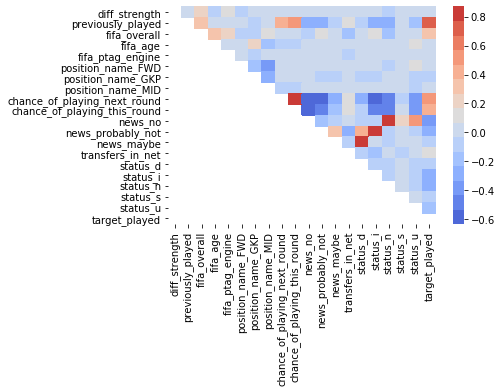

In [81]:
import seaborn as sns
col_corr = new_use.corr(method='spearman')
mask = np.tril(np.ones_like(col_corr, dtype=np.bool))

sns.heatmap(col_corr,
            cmap=sns.color_palette("coolwarm", 15),
            mask=mask)

Though the above confirms that `previously_played` is the most useful feature, some other do have noticeable correlation with the response so may be useful.

In [82]:
X_all_new = new_use[new_features]
y_all_new = new_use[new_response]
X_test_new = new_test[new_features]
y_test_new = new_test[new_response]
grps_new = new_data.loc[new_data.player_id.isin(player_ids_use), 'player_id']

Repeating the same process as earlier, but removing the no-longer needed step of calculating percentages across groups.

In [83]:
shared = [('ss', StandardScaler()),
          ('pca', PCA(n_components=0.95, svd_solver='full'))]

pipe_lr = Pipeline(
    shared +
    [('clf', LogisticRegression(solver='liblinear'))]
)
params_lr = {
     'clf__penalty': ['l1', 'l2'],
     'clf__C': np.logspace(-3, 3, 7)
}

Refitting the model. For now I'll stick with logistic regression as it is quicker to train with fewer parameters to tune.

In [84]:
scores_lr, model_lr = cross_val_scorer_grouped(pipe_lr, params_lr, X_all_new, y_all_new, groups=grps_new,
                                                 scoring='accuracy', cv_inner=gkf, gs_verbosity=1)

0
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   20.6s finished


Fold 0 complete
1
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   39.1s finished


Fold 1 complete
2
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   37.1s finished


Fold 2 complete
3
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   24.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fold 3 complete
4
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   36.4s finished


Fold 4 complete


In [86]:
print(f'Nested CV accuracy for logistic regression: {np.mean(scores_lr):.4f} +/- {np.std(scores_lr):2f}')

Nested CV accuracy for logistic regression: 0.8383 +/- 0.011974


The model compares favourably compared to the earlier ones. I will stop here as I don't think much better will be possible without a lot more effort.

In [88]:
gs_final = GridSearchCV(estimator=pipe_lr, param_grid=params_lr,
                        scoring='accuracy', cv=gkf, verbose=1)
gs_final.fit(X_all_new, y_all_new, groups=grps_new)
preds_lr_test = gs_final.predict(X_test_new)
print(f'Accuracy score on test: {accuracy_score(preds_lr_test, y_test_new):.2%}')

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:  1.5min finished


Accuracy score on test: 85.77%


A small improvement from using the new features is apparent.

Finally, save to S3. If it makes sense to later on, I can write a Python program to be able to retrain the model (uploading the updated version).

In [91]:
import io
model_out = 'models/playing/model_00.pkl'

s3 = boto3.client('s3')

buff = io.BytesIO()

obj = pickle.dumps(gs_final)
s3.put_object(Bucket='fpl-alldata', Key=model_out, Body=obj)

{'ResponseMetadata': {'RequestId': '6FDC2B286440CFB7',
  'HostId': 'U3Z+uy/peQu+lGdiIh8wdKrh9BPM3Wyu7D36zedPoTXP6Rx+/VuX2QlyO1+DIrnoNK0+8MLcOvY=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'U3Z+uy/peQu+lGdiIh8wdKrh9BPM3Wyu7D36zedPoTXP6Rx+/VuX2QlyO1+DIrnoNK0+8MLcOvY=',
   'x-amz-request-id': '6FDC2B286440CFB7',
   'date': 'Sat, 13 Jun 2020 11:41:35 GMT',
   'x-amz-version-id': '6BCoM9eedV3B.IfuNFEfjBqXMw2SrPCK',
   'etag': '"5ded26dd6a07fe52e55f403c6ad84df0"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"5ded26dd6a07fe52e55f403c6ad84df0"',
 'VersionId': '6BCoM9eedV3B.IfuNFEfjBqXMw2SrPCK'}